In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(19)
import xgboost as xgb
import catboost as ctb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from collections import defaultdict
from sklearn.dummy import DummyRegressor
import scikitplot as skplt
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# Dane

In [2]:
# wczytaj dane
train = pd.read_hdf('../input/train.car_price.h5')
test = pd.read_hdf('../input/test.car_price.h5') #zbiór testowy bez odpowiedzi

In [3]:
# połącz dane
df_all = pd.concat([train, test])

In [4]:
# wypełnij braki -1, poza ceną w teście
df_all.loc[:, df_all.columns != 'price_value'] = df_all.fillna(-1)

# Przydatne funkcje

In [5]:
remove_feats = ["car_id", 'price_details_cat', 'price_value', 'index']

In [6]:
def get_feats(df):
    feats = df.select_dtypes(include = [np.number, np.bool]).columns
    feats = [x for x in feats if x not in remove_feats]
    return feats

def get_train(df):
    return df[~df["price_value"].isnull()]
def get_test(df):
    return df[df["price_value"].isnull()]
def get_X(df):
    return df[feats].values
def get_y(df):
    return df['price_value'].values

def str_to_num(param, strip_value):
    # usuń strip # usuń spacje
    df_all[param] = df_all[param].astype(str).str.rstrip(strip_value).str.replace(" ","").astype(float)
    remove_feats.extend(['{0}_cat'.format(param)])
    
# nowa funkcja, gdy kolumna zawiera floaty rozdzielone przecinkiem
def str_to_float(param, strip_value):
    # usuń strip # usuń spacje # wymień , na .
    df_all[param] = df_all[param].astype(str).str.rstrip(strip_value).str.replace(" ","").str.replace(",", ".").astype(float)
    remove_feats.extend(['{0}_cat'.format(param)])
    
# funkcja do tworzenia cechy będącej kombinacją polskiego i angielksiego odpowiednika
# zwykle zmniejsza to liczbę wartości brakujących
def eng_pl(col_eng, col_pl):
    df_all['{0}_comb'.format(col_pl)] = df_all[col_pl]
    df_all.loc[df_all['{0}_comb'.format(col_pl)] == -1, '{0}_comb'.format(col_pl)] = df_all.loc[df_all['{0}_comb'.format(col_pl)] == -1, col_eng]
    #df_all['{0}_comb'.format(col_pl)] = df_all['{0}_comb'.format(col_pl)].astype(int)
    remove_feats.extend(['{0}_cat'.format(col_pl), '{0}_cat'.format(col_eng)])


# Feature Engineering

## Target log

(array([2.2000e+01, 4.2900e+02, 2.1780e+03, 9.6450e+03, 2.5098e+04,
        3.2097e+04, 2.1279e+04, 1.0951e+04, 3.9550e+03, 8.4000e+02]),
 array([ 5.99146455,  6.75154229,  7.51162004,  8.27169778,  9.03177553,
         9.79185327, 10.55193102, 11.31200876, 12.07208651, 12.83216425,
        13.592242  ]),
 <a list of 10 Patch objects>)

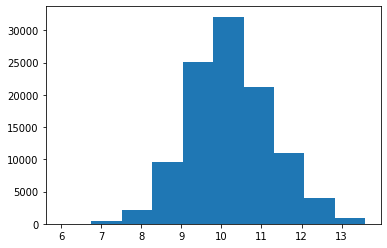

In [7]:
#plt.hist(train.price_value) # nie wygląda dobrze - wartości gromadzą się z przodu
plt.hist(np.log(train.price_value)) # wygląda bardziej normalnie - użyj log

## Powrót do breadcrumb

(najpierw zignorowałam tę kolumnę, bo nie ma tam nic czego nie ma w innych kolumnach, ale potem zauważyłam, że rozbicie jej może zmiejszyć liczbę brakujących wartości)

In [8]:
sum(df_all['breadcrumb'] == -1) # no missing! (później zauważyłam, że możliwe, że to dlatego, że mają to inaczej oznaczone, ale już nic z tym nie robiłam)

0

In [9]:
#df_all['breadcrumb'].str.split(',')
df_all['bread_list'] = [','.join(map(str, l)) for l in df_all['breadcrumb']]

In [10]:
df_all['Osobowe_br'] = df_all['bread_list'].str.split(',', expand = True)[0]

In [11]:
df_all['Marka_br'] = df_all['bread_list'].str.split(',', expand = True)[1]

In [12]:
sum(df_all['Marka_br'].value_counts()>1)

89

In [13]:
# zgrupuj marki, które występują tylko raz do 'other'
# top 89 makes + 'other' 
top_makes = list(df_all['Marka_br'].value_counts().head(89).keys())
makes_norm = defaultdict(lambda: 'other', dict(zip(top_makes, top_makes)))
df_all['makes_norm'] = df_all['Marka_br'].map(makes_norm)
#df_all['makes_norm'].value_counts()
#df_all['seller_address_norm_cat'] = pd.factorize(df_all['seller_address_norm'])[0]

In [14]:
df_all['Model_br'] = df_all['bread_list'].str.split(',', expand = True)[2]

In [15]:
sum(df_all['Model_br'].value_counts() > 1)

904

In [16]:
# zgrupuj modele, które wsytępują tylko raz do 'other'
# top 904 models + 'other'
top_model = list(df_all['Model_br'].value_counts().head(904).keys())
model_norm = defaultdict(lambda: 'other', dict(zip(top_model, top_model)))
df_all['model_norm'] = df_all['Model_br'].map(model_norm)
df_all['model_norm'].value_counts()

Astra        4766
Passat       4343
Seria 3      4036
Golf         4006
A4           3748
             ... 
Interstar       2
Sedona          2
Delta 88        2
Tercel          2
Tahoe           2
Name: model_norm, Length: 905, dtype: int64

In [17]:
df_all['Full_car_name_br'] = df_all['bread_list'].str.split(',', expand = True)[3]

In [18]:
df_all = df_all.drop(columns = 'bread_list')

In [19]:
sum(df_all['Full_car_name_br'].value_counts() > 1)

802

In [20]:
# zgrupuj wersje, które wsytępują tylko raz do 'other'
# top 802 models + 'other'
top_name = list(df_all['Full_car_name_br'].value_counts().head(802).keys())
name_norm = defaultdict(lambda: 'other', dict(zip(top_name, top_name)))
df_all['name_norm'] = df_all['Full_car_name_br'].map(name_norm)
#df_all['name_norm'].value_counts()

## Faktoryzacja danych nienumerycznych

In [21]:
cat_f = df_all.select_dtypes(include = [np.object]).columns
cat_f = cat_f.drop(["breadcrumb", 'param_marka-pojazdu', 'param_make', 'param_model', 'param_model-pojazdu', 'param_wersja', 'param_version', 'param_kategoria', 'Full_car_name_br', 'Marka_br', 'Model_br']) # z breadcrumb poradziłam sobie z nią powyżej
for cat_feat in cat_f:
    df_all['{0}_cat'.format(cat_feat)] = pd.factorize(df_all[cat_feat])[0]

## Wyciągnij coś z created_at

In [22]:
df_all['created_at'].value_counts() # factorized jest bezużyteczne, trzeba to rozdzielić

12:13, 2 marca 2018      191
22:19, 28 lutego 2018    168
12:14, 2 marca 2018      164
12:17, 2 marca 2018      162
-1                       161
                        ... 
03:42, 3 marca 2018        1
04:33, 15 lutego 2018      1
06:52, 3 marca 2018        1
20:59, 26 lutego 2018      1
15:32, 26 lutego 2018      1
Name: created_at, Length: 11960, dtype: int64

In [23]:
remove_feats.extend(['created_at_cat'])
#remove_feats

In [24]:
df_all['created_at'][0].split(sep = ',')[0]
df_all['created_at'].str[:2]
df_all['created_at'].str[7:].value_counts()

5 marca 2018        30386
4 marca 2018        25906
3 marca 2018        23774
2 marca 2018        23439
1 marca 2018        18859
28 lutego 2018      16245
27 lutego 2018      13868
26 lutego 2018       1684
23 lutego 2018       1520
24 lutego 2018       1366
25 lutego 2018       1269
22 lutego 2018       1014
6 marca 2018          402
20 lutego 2018        122
19 lutego 2018         83
21 lutego 2018         82
9 lutego 2018          60
10 lutego 2018         50
15 lutego 2018         50
16 lutego 2018         32
14 lutego 2018         31
12 lutego 2018         29
13 lutego 2018         28
11 lutego 2018         28
6 lutego 2018          26
17 lutego 2018         24
8 lutego 2018          22
7 lutego 2018          12
18 lutego 2018          8
29 stycznia 2018        7
9 marca 2018            4
30 stycznia 2018        4
28 stycznia 2018        4
31 stycznia 2018        3
11 stycznia 2018        2
8 marca 2018            2
28 grudnia 2017         1
1 lutego 2018           1
9 stycznia 2

In [25]:
# ile miesięcy temu było dodane ogłoszenie
df_all['created_M_ago'] = df_all['created_at']

In [26]:
df_all.loc[df_all['created_at'].str.contains('marca', na = False), 'created_M_ago'] = 0
df_all.loc[df_all['created_at'].str.contains('lutego', na = False), 'created_M_ago'] = 1
df_all.loc[df_all['created_at'].str.contains('stycznia', na = False), 'created_M_ago'] = 2
df_all.loc[df_all['created_at'].str.contains('grudnia', na = False), 'created_M_ago'] = 3

In [27]:
df_all['created_M_ago'] = df_all['created_M_ago'].astype(int)

Wg modelu 36 ta wiedza pogarsza wynik :( ale i tak ją zostawię...

## Adres sprzedawcy

In [28]:
#ac = df_all['seller_address'].value_counts()
#len(ac) # 12,809
#sum(ac<50) # 12,192 sell less than 50
#sum(ac == 1)
#ac[-12192:]
remove_feats.extend(['seller_address_cat'])

In [29]:
# top 50 addresses + 'other'
top_addresses = list(df_all['seller_address'].value_counts().head(50).keys())
address_norm = defaultdict(lambda: 'other', dict(zip(top_addresses, top_addresses)))
df_all['seller_address_norm'] = df_all['seller_address'].map(address_norm)
df_all['seller_address_norm'].value_counts()
df_all['seller_address_norm_cat'] = pd.factorize(df_all['seller_address_norm'])[0]

## Nazwa sprzedawcy

Po obejrzeniu histogramu chciałam stworzyć kategorię dla małych, średnich, dużych sprzedawców wg bucketów poniżej, ale mnie to przerosło, więc zamiast tego zrobiłam factorize na top 50 sprzedawców i wrzuciłam resztę do 'other'.

In [30]:
#plt.hist(sc_mid)
#sc_mid.value_counts()
# -1: 0
# 1: 1
# 2 - 3: 2
# 4 - 5: 3
# 6 - 10: 4
# 10 - 20: 5
# 20 - 30: 6
# 30 - 100:7
# 100 +: 8
#r1 = sc[:803]

In [31]:
# top 50 sellers' names and 'others'
top_sellers = list(df_all['seller_name'].value_counts().head(50).keys())
seller_norm = defaultdict(lambda: 'other', dict(zip(top_sellers, top_sellers)))
df_all['seller_name_norm'] = df_all['seller_name'].map(seller_norm)
df_all['seller_name_norm'].value_counts()
df_all['seller_name_norm_cat'] = pd.factorize(df_all['seller_name_norm'])[0]
remove_feats.extend(['seller_name_cat'])

## Stringi, które powinny być numerami

In [32]:
str_to_float('param_wartość-wykupu', 'PLN')

In [33]:
str_to_float('param_liczba-pozostałych-rat', '')

In [34]:
str_to_float('param_opłata-początkowa', 'PLN')

## Total features
zamiast feature_ boolean - ale okazało się, że daje to gorszy wynik

In [35]:
# how many features does a record have
#df_all['nfeature'] = -1
#len(df_all['nfeature'])

In [36]:
features = df_all.columns[df_all.columns.str.contains("feature_")]

In [37]:
#(df_all[features] == -1).sum().sum() ## wszystkie features to True/False

In [38]:
#df_all['nfeature'] = df_all[features].sum(axis=1)

### Expensive features

Żeby sprawdzić, które 'features' pogrupować żeby pomóc modelowi rozpoznawać droższe samochody:
    1. sprawdziłam korelację między features i ceną
    2. uruchomiłam model na samych features i sprawdziłam, które najbardziej wpłynęły na wynik (z eli5)

In [39]:
features_corr = list(features)
features_corr.extend(['price_value'])

In [40]:
feats_corr = train[features_corr].astype(int)

In [41]:
corrs = pd.DataFrame(feats_corr.corr().loc['price_value', :])

In [42]:
corrs.sort_values(by = 'price_value', inplace = True, ascending = False)
#len(corrs)
#sns.heatmap(corrs)

In [43]:
corrs.head(10)

,price_value
price_value,1.000000
feature_kamera-cofania,0.464058
feature_światła-led,0.434708
feature_łopatki-zmiany-biegów,0.426042
feature_system-start-stop,0.421750
feature_czujniki-parkowania-przednie,0.400076
feature_asystent-pasa-ruchu,0.378468
feature_bluetooth,0.365952
feature_nawigacja-gps,0.360922
feature_czujnik-martwego-pola,0.346648


(Model uruchomiłam w innym miejscu, lista poniżej zawiera już cechy wybrane z obu metod)

In [44]:
fancy = ['feature_kamera-cofania', 'feature_światła-led', 'feature_system-start-stop', 'feature_łopatki-zmiany-biegów', 'feature_czujniki-parkowania-przednie', 'feature_bluetooth', 'feature_światła-do-jazdy-dziennej']

In [45]:
df_all['fancy_feats'] = df_all[fancy].sum(axis=1)

### Czy cechy po angielsku uzupełniają sie może z tymi po polsku...?

Zauważyłam, że wiele cech występuje podwójnie - po polsku i angielsku i połączyłam je razem. Pierwsze kilka robiłam manualnie, potem napisałam do tego funkcję.

In [46]:
# 1. przebieg vs mileage
# przebieg nie ma żadnych brakujących wartości!
eng_pl('param_mileage', 'param_przebieg')
str_to_num('param_przebieg_comb', 'km')
df_all['param_przebieg_comb'].value_counts() # log może się tu przydać

1.0         6125
5.0         4339
10.0        1673
180000.0    1312
220000.0    1305
            ... 
170590.0       1
60124.0        1
21324.0        1
66839.0        1
262142.0       1
Name: param_przebieg_comb, Length: 33586, dtype: int64

In [47]:
# 2 country_of _origin vs kraj_pochodzenia
#df_all['param_country-of-origin'].value_counts() # 160,534 nie ma
#df_all['param_kraj-pochodzenia'].value_counts() # 51,466 nie ma
df_all.loc[(df_all['param_kraj-pochodzenia'] == -1) & (df_all['param_country-of-origin'] != -1), ['param_kraj-pochodzenia', 'param_country-of-origin']]
# są wypadki gdy nie ma w kraj, a jest w country # 82
#df_all.loc[(df_all['param_kraj-pochodzenia'] != -1) & (df_all['param_country-of-origin'] == -1), ['param_kraj-pochodzenia', 'param_country-of-origin']]
df_all.loc[(df_all['param_kraj-pochodzenia'] != df_all['param_country-of-origin']), ['param_kraj-pochodzenia', 'param_country-of-origin']]
# 109,232 gdzie wartości się nie zgadzają między tymi 2 kolumnami - czyli żadna poza brakującymi przypadkami
df_all['param_kraj-pochodzenia_comb'] = df_all['param_kraj-pochodzenia']
df_all.loc[df_all['param_kraj-pochodzenia_comb']==-1, 'param_kraj-pochodzenia_comb'] = df_all.loc[df_all['param_kraj-pochodzenia_comb']==-1,'param_country-of-origin']

Zgrupuj razem kraje z małymi ilościami samochodów.

In [48]:
counts = df_all['param_kraj-pochodzenia_comb'].value_counts()
others = counts[counts<10].index
df_all['param_kraj-pochodzenia_comb'] = df_all['param_kraj-pochodzenia_comb'].replace(others, 'Inny')
df_all['param_kraj-pochodzenia_comb_cat'] = pd.factorize(df_all['param_kraj-pochodzenia_comb'])[0]
remove_feats.extend(['param_kraj-pochodzenia_cat', 'param_country-of-origin_cat'])

In [49]:
# 3 param_year vs param_rok
df_all['param_year'].value_counts() #mostly missing
df_all['param_rok-produkcji'].value_counts() # 289 missing

df_all.loc[(df_all['param_rok-produkcji'] == -1) & (df_all['param_year'] != -1), ['param_rok-produkcji', 'param_year']] # ok

df_all['param_rok_comb'] = df_all['param_rok-produkcji']
df_all.loc[df_all['param_rok_comb']==-1, 'param_rok_comb'] = df_all.loc[df_all['param_rok_comb']==-1,'param_year']
sum(df_all['param_rok_comb'] == -1) # 161< 289

remove_feats.extend(['param_rok-produkcji_cat', 'param_year_cat'])

In [50]:
df_all['param_rok_comb'] = df_all['param_rok_comb'].astype(int)

## Przybliż pozostałe roki

Rok jest najważniejszą cechą modelu, więc chciałam uzupełnić go dla wszystkich aut. Poniżej przybliżam rok na podstawie modelu (patrząc na to z którego roku są średnio inne samochody tego modelu w moich danych).

In [51]:
# czy mogę przybliżyć brakujący rok znając rocznik wersji samochodu? nie, bo tam tez sa w tych miejscach brakujace wartosci
len(df_all.loc[df_all['param_rok_comb']==-1, ['Full_car_name_br']])
idx = df_all.loc[df_all['param_rok_comb']==-1].index # idx w których potrzebuję roku

In [52]:
df_all['Model_br'] = [x.replace('-', ' ') for x in df_all['Model_br']] # usuń - z modelów

In [53]:
car_models = list(df_all.loc[idx, 'Model_br'])

In [54]:
missing_cars = []
missing_years = []
for car in car_models: # możliwe, że nie jest to efektywna metoda, bo trochę czasu ta pętla zajmuje...
   # podobne samochody to tych, którym brakuje roku 
    sim_cars = df_all[df_all['Full_car_name_br'].str.contains(car, na=False)] 
   # średni rok produkcji podobnych samochodów
    sim_year = pd.DataFrame(sim_cars[['Full_car_name_br', 'param_rok_comb']].groupby(['Full_car_name_br']).mean().mean().round()).values
    
    missing_cars.append(car)
    try:
        missing_years.append(int(sim_year))
    except:
        missing_years.append(-1)
df = pd.DataFrame({'car': missing_cars, 'year': missing_years})
del missing_cars, missing_years

In [55]:
# uzupełnij w df_all
df_help = df_all.loc[idx]
df_all.loc[idx, 'param_rok_comb'] = df_help['Model_br'].replace(dict(zip(df.car, df.year)))


In [56]:
# 4 damaged - uszkodzony
eng_pl('param_damaged', 'param_uszkodzony')
df_all['param_uszkodzony_comb'] = pd.factorize(df_all['param_uszkodzony_comb'])[0]

In [57]:
# 5 metallic vs metalik
eng_pl('param_metallic', 'param_metalik')

In [58]:
df_all['param_metalik_comb'] = pd.factorize(df_all['param_metalik_comb'])[0]

In [59]:
# 6 nr-of-seats vs liczba-miejsc
eng_pl('param_nr-of-seats', 'param_liczba-miejsc')

In [60]:
df_all['param_liczba-miejsc_comb'] = df_all['param_liczba-miejsc_comb'].astype(int)

In [61]:
# 7 drzwi
eng_pl('param_door-count', 'param_liczba-drzwi')

In [62]:
df_all['param_liczba-drzwi_comb'] = df_all['param_liczba-drzwi_comb'].astype(int)

In [63]:
# 8 rejestracja
eng_pl('param_first-registration', 'param_pierwsza-rejestracja')

Wrócę do tego żeby wyjąć rok.

In [64]:
# 9 perła
eng_pl('param_pearl', 'param_perłowy')

In [65]:
df_all['param_perłowy_comb'] = pd.factorize(df_all['param_perłowy_comb'])[0]

In [66]:
# 10 rejestracja w pl
eng_pl('param_registered-in-poland', 'param_zarejestrowany-w-polsce')

In [67]:
df_all['param_zarejestrowany-w-polsce_comb'] = pd.factorize(df_all['param_zarejestrowany-w-polsce_comb'])[0]

In [68]:
# 11 kolor
eng_pl('param_color', 'param_kolor')

In [69]:
df_all['param_kolor_comb'] = pd.factorize(df_all['param_kolor_comb'])[0]

In [70]:
# 12 pierwszy właściciel
eng_pl('param_original-owner', 'param_pierwszy-właściciel')

In [71]:
df_all['param_pierwszy-właściciel_comb'] = pd.factorize(df_all['param_pierwszy-właściciel_comb'])[0]

In [72]:
# 13 wypadki
eng_pl('param_no-accident', 'param_bezwypadkowy')

In [73]:
df_all['param_bezwypadkowy_comb'] = pd.factorize(df_all['param_bezwypadkowy_comb'])[0]

In [74]:
# 14 paliwo
eng_pl('param_fuel-type', 'param_rodzaj-paliwa')

In [75]:
df_all['param_rodzaj-paliwa_comb'] = pd.factorize(df_all['param_rodzaj-paliwa_comb'])[0]

In [76]:
# 15 rata
eng_pl('param_monthly-payment-value', 'param_miesięczna-rata')

In [77]:
df_all['param_miesięczna-rata_comb'].value_counts() # trzeba rozbić:
#str_to_num('param_miesięczna-rata_comb', 'PLN') # funkcja nie działa, bo floaty mają przeciniki, trzeba zmienić

-1            159889
400 PLN           28
600 PLN           21
500 PLN           15
700 PLN           13
               ...  
837 PLN            1
892,22 PLN         1
4 546 PLN          1
496 PLN            1
1 555 PLN          1
Name: param_miesięczna-rata_comb, Length: 534, dtype: int64

In [78]:
# nowa funkcja, gdy kolumna zawiera floaty rozdzielone przecinkiem
#def str_to_float(param, strip_value):
#    # usuń strip # usuń spacje # wymień , na .
#    df_all[param] = df_all[param].astype(str).str.rstrip(strip_value).str.replace(" ","").str.replace(",", ".").astype(float)
#    remove_feats.extend(['{0}_cat'.format(param)])

In [79]:
str_to_float('param_miesięczna-rata_comb', 'PLN')

In [80]:
# 16 emisje co2
eng_pl('param_co2-emissions', 'param_emisja-co2')

In [81]:
df_all['param_emisja-co2_comb'].unique()
str_to_num('param_emisja-co2_comb', 'g/km')

In [82]:
# 17 marka - niepotrzebna po breadcrumbie
#eng_pl('param_make', 'param_marka-pojazdu')
#df_all['param_marka-pojazdu_comb'] = pd.factorize(df_all['param_marka-pojazdu_comb'])[0]

In [83]:
# 18 skrzynia biegów
df_all['param_skrzynia-biegów'].value_counts()
eng_pl('param_gearbox', 'param_skrzynia-biegów')

In [84]:
df_all['param_skrzynia-biegów_comb'] = pd.factorize(df_all['param_skrzynia-biegów_comb'])[0]

In [85]:
# 19 kod silnika - wyrzuć, bezużyteczny jako factor
remove_feats.extend(['param_engine-code_cat', 'param_kod-silnika_cat'])
#eng_pl('param_engine-code', 'param_kod-silnika')

In [86]:
#df_all['param_kod-silnika_comb'].value_counts()
#df_all['param_kod-silnika_comb'] = pd.factorize(df_all['param_kod-silnika_comb'])[0]
#df_all['param_kod-silnika_comb'].value_counts()

In [87]:
# 20 model - niepotrzebne po breadcrumbie
#df_all['param_model-pojazdu']
#df_all['param_model'].value_counts()
#eng_pl('param_model', 'param_model-pojazdu')
#df_all['param_model-pojazdu_comb'] = pd.factorize(df_all['param_model-pojazdu_comb'])[0]

In [88]:
# 21 moc silnika
df_all['param_moc']
#df_all['param_engine-power'].value_counts()
eng_pl('param_engine-power', 'param_moc')

In [89]:
#str_to_num('param_moc_comb', 'KM') KM i HP obecne
# funkcja gdy trzeba usunąć 2 stringi
def str_to_num2(param, strip_value1, strip_value2):
    # usuń strip # usuń spacje # wymień , na .
    df_all[param] = df_all[param].astype(str).str.rstrip(strip_value1).str.rstrip(strip_value2).str.replace(" ","").astype(float)
    remove_feats.extend(['{0}_cat'.format(param)])

In [90]:
str_to_num2('param_moc_comb', 'KM', 'HP')

In [91]:
# 22 body type - przeniesione do działu z one-hot-encoding
#df_all['param_typ'].value_counts()
#eng_pl('param_body-type', 'param_typ')

In [92]:
# 23: wersja - niepotrzebne po breadcrumbie
#df_all['param_version'].value_counts()
#eng_pl('param_version', 'param_wersja')

In [93]:
# 24 napęd
df_all['param_transmission'].value_counts()
eng_pl('param_transmission', 'param_napęd')

In [94]:
df_all['param_napęd_comb'] = pd.factorize(df_all['param_napęd_comb'])[0]

In [95]:
# 25 filtr
df_all['param_particle-filter'].value_counts()
df_all['param_filtr-cząstek-stałych']
eng_pl('param_particle-filter', 'param_filtr-cząstek-stałych')

In [96]:
df_all['param_filtr-cząstek-stałych_comb'] = pd.factorize(df_all['param_filtr-cząstek-stałych_comb'])[0]

In [97]:
# 26 akryl
eng_pl('param_acrylic', 'param_akryl-(niemetalizowany)')

In [98]:
df_all['param_akryl-(niemetalizowany)_comb'].value_counts()

-1         154473
Tak          6137
acrylic         6
Name: param_akryl-(niemetalizowany)_comb, dtype: int64

In [99]:
df_all['param_akryl-(niemetalizowany)_comb'] = df_all['param_akryl-(niemetalizowany)_comb'].replace("acrylic", "Tak")
df_all['param_akryl-(niemetalizowany)_comb'] = pd.factorize(df_all['param_akryl-(niemetalizowany)_comb'])[0]

In [100]:
# 27 serwis
df_all['param_serwisowany-w-aso'].value_counts()
eng_pl('param_service-record', 'param_serwisowany-w-aso')
df_all['param_serwisowany-w-aso_comb'] = pd.factorize(df_all['param_serwisowany-w-aso_comb'])[0]

In [101]:
# 28 finansowanie
eng_pl('param_financing-option', 'param_możliwość-finansowania')
df_all['param_możliwość-finansowania_comb'].value_counts()
df_all['param_możliwość-finansowania_comb'] = pd.factorize(df_all['param_możliwość-finansowania_comb'])[0]

In [102]:
# 29 leasing
df_all['param_leasing'].value_counts()
df_all['param_leasing-concession'].value_counts()
eng_pl('param_leasing-concession', 'param_leasing')
df_all['param_leasing_comb'] = pd.factorize(df_all['param_leasing_comb'])[0]

In [103]:
#df_all['param_oferta-od'].value_counts() # firma / osoba prywatna
# vin: rejestracja - raczej nie będzie miało to znaczenia...
remove_feats.extend(['param_vin_cat'])

In [104]:
# 30 vat free
eng_pl('param_vat-free', 'param_homologacja-ciężarowa')
df_all['param_homologacja-ciężarowa_comb'] = pd.factorize(df_all['param_homologacja-ciężarowa_comb'])[0]

In [105]:
# 32 vat disc
eng_pl('param_vat-discount', 'param_vat-marża')
df_all['param_vat-marża_comb'] = pd.factorize(df_all['param_vat-marża_comb'])[0]

In [106]:
# 33 pojemność skokowa
eng_pl('param_engine-capacity', 'param_pojemność-skokowa')
str_to_float('param_pojemność-skokowa_comb', 'cm3')

In [107]:
#df_all['param_pojemność-skokowa_comb'].unique()
df_all['param_pojemność-skokowa_comb'] = df_all['param_pojemność-skokowa_comb'].astype(float)

### Log przebiegu

(array([5.4400e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00, 6.1250e+03,
        9.5100e+02, 5.0620e+03, 2.6310e+03, 3.3400e+02, 1.1300e+02,
        4.1000e+01, 1.3300e+02, 1.0700e+02, 2.0600e+02, 3.3400e+02,
        5.0200e+02, 9.1000e+02, 1.8580e+03, 3.5010e+03, 5.2450e+03,
        7.1890e+03, 1.4543e+04, 5.1622e+04, 5.6538e+04, 1.9820e+03,
        5.4000e+01, 4.0000e+01, 3.2000e+01, 1.5000e+01, 3.0000e+00]),
 array([-2.30258509, -1.67594628, -1.04930746, -0.42266864,  0.20397018,
         0.83060899,  1.45724781,  2.08388663,  2.71052544,  3.33716426,
         3.96380308,  4.5904419 ,  5.21708071,  5.84371953,  6.47035835,
         7.09699716,  7.72363598,  8.3502748 ,  8.97691362,  9.60355243,
        10.23019125, 10.85683007, 11.48346888, 12.1101077 , 12.73674652,
        13.36338534, 13.99002415, 14.61666297, 15.24330179, 15.8699406 ,
        16.49657942]),
 <a list of 30 Patch objects>)

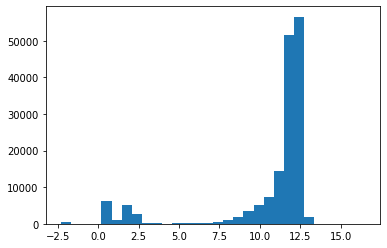

In [108]:
plt.hist(np.log(df_all['param_przebieg_comb'] + 1.1), bins = 30) # +1.1 żeby nie było zer, które dają -inf

In [109]:
df_all['param_przebieg_log'] = np.log(df_all['param_przebieg_comb']+1.1)
remove_feats.extend(['param_przebieg_comb'])

#### Pomogło, może log może pomóc też w innych kolumnach...

/home/conda/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/conda/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/conda/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


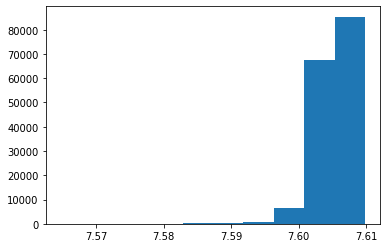

In [110]:
plt.hist(np.log(df_all['param_rok_comb'])) # spróbujmy rok
df_all['rok_log'] = np.log(df_all['param_rok_comb'] + 2) # żeby nie było NaN dla -1
remove_feats.extend(['param_rok_comb'])

#### Pomogło, próbowałam zamienić też inne ciągłe zmienne na log, ale psuło to już wynik, więc wróciłam do tylko roku i przebiegu w logu.

# One-hot-encoding

In [111]:
# typ samochodu / body type

# zmniejsz liczbę kategorii
df_all['param_typ_sim'] = df_all['param_typ'].replace({'others': -1, 'not enough details': -1, 'sedan/coupe/cabrio': 'Sedan', 'hatchback': 'Kombi', 'sedan/coupe': 'Sedan', 'coupe/cabrio': 'Coupe', 'minivan/city-car': 'Minivan', 'compact/minivan': 'Kompakt', 'city-car/suv': 'SUV', 'coupe/cabrio/minivan': 'Minivan',
                                'compact/sedan': 'Sedan'})
     

In [112]:
eng_pl('param_body-type', 'param_typ_sim')
df_all['param_typ_sim_comb'].value_counts()

Kombi            33055
Sedan            27137
Kompakt          24867
SUV              24266
Auta miejskie    20532
Minivan          19792
Auta małe         5407
Coupe             4048
Kabriolet         1348
-1                 164
Name: param_typ_sim_comb, dtype: int64

In [113]:
df_ohe = pd.get_dummies(df_all['param_typ_sim_comb'], prefix='typ')
df_ohe = df_ohe.drop(columns = 'typ_-1')
df_ohe.columns

Index(['typ_Auta małe', 'typ_Auta miejskie', 'typ_Coupe', 'typ_Kabriolet',
       'typ_Kombi', 'typ_Kompakt', 'typ_Minivan', 'typ_SUV', 'typ_Sedan'],
      dtype='object')

In [114]:
df_all = pd.concat([df_all, df_ohe], axis = 1)

In [115]:
remove_feats.extend(['param_typ_comb', 'param_typ_cat'])

Test na modelu 24 - poprawiło wynik.

### One hot na napędzie

In [116]:
df_all['param_napęd'].value_counts(normalize=True, dropna=False)

Na przednie koła                 0.619770
-1                               0.153926
Na tylne koła                    0.080671
4x4 (stały)                      0.066208
4x4 (dołączany automatycznie)    0.064340
4x4 (dołączany ręcznie)          0.015086
Name: param_napęd, dtype: float64

In [117]:
df_ohen = pd.get_dummies(df_all['param_napęd'], prefix='napęd')
df_ohen = df_ohen.drop(columns = 'napęd_-1')
df_ohen.columns

Index(['napęd_4x4 (dołączany automatycznie)', 'napęd_4x4 (dołączany ręcznie)',
       'napęd_4x4 (stały)', 'napęd_Na przednie koła', 'napęd_Na tylne koła'],
      dtype='object')

In [118]:
df_all.shape, df_ohen.shape

((160616, 288), (160616, 5))

In [119]:
df_all = pd.concat([df_all, df_ohen], axis = 1)

In [120]:
#df_ext.shape

In [121]:
remove_feats.extend(['param_napęd_comb'])

Poprawiło to wynik.

In [122]:
# dodaj automat

In [123]:
df_all['param_skrzynia-biegów'].value_counts()

Manualna                                 110590
Automatyczna hydrauliczna (klasyczna)     27935
Automatyczna dwusprzęgłowa (DCT, DSG)      9623
-1                                         8866
Automatyczna bezstopniowa (CVT)            2300
Półautomatyczna (ASG, Tiptronic)           1302
Name: param_skrzynia-biegów, dtype: int64

In [124]:
df_all['automat'] = df_all['param_skrzynia-biegów'].replace('Manualna', 0)

In [125]:
df_all.loc[df_all['automat'] != 0, 'automat'] = 1

In [126]:
df_all['automat'] = df_all['automat'].astype(bool)

## One hot encoding: rodzaj paliwa

In [166]:
#df_all['param_fuel-type'].value_counts()
eng_pl('param_fuel-type', 'param_rodzaj-paliwa')
#df_all['param_rodzaj-paliwa_comb'] = pd.factorize(df_all['param_rodzaj-paliwa_comb'])[0]
df_all['param_rodzaj-paliwa_comb'].head()

0    Benzyna+LPG
2         Diesel
3         Diesel
4         Diesel
5        Benzyna
Name: param_rodzaj-paliwa_comb, dtype: object

In [167]:
df_all['param_rodzaj-paliwa_comb'].value_counts()
df_ohep = pd.get_dummies(df_all['param_rodzaj-paliwa_comb'], prefix='paliwo')
df_ohep['paliwo_inne'] = df_ohep['paliwo_Wodór'] + df_ohep['paliwo_Etanol']
df_ohep = df_ohep.drop(columns = ['paliwo_-1', 'paliwo_Wodór', 'paliwo_Etanol'])
df_ohep.columns

Index(['paliwo_Benzyna', 'paliwo_Benzyna+CNG', 'paliwo_Benzyna+LPG',
       'paliwo_Diesel', 'paliwo_Elektryczny', 'paliwo_Hybryda', 'paliwo_inne'],
      dtype='object')

In [168]:
df_all = pd.concat([df_all, df_ohep], axis = 1)

In [169]:
remove_feats.extend(['param_rodzaj-paliwa_comb'])

In [131]:
#feats = get_feats(df_all)
#feats

In [132]:
# napraw mat
df_all['param_matowy'].value_counts()

-1      160122
Tak        492
matt         2
Name: param_matowy, dtype: int64

In [133]:
df_all['param_matowy'] = df_all['param_matowy'].replace({-1: 0, 'Tak': 1, 'matt': 1})

In [134]:
remove_feats.extend(['param_matowy_cat'])

In [135]:
#df_all['param_stan_cat'].value_counts() zrób oddzielną bool kolumnę na używane/nowe
df_all['używane'] = df_all['param_stan_cat'].replace(2, 0)
remove_feats.extend(['param_stan_cat'])

## Średnia cena modelu

In [136]:
train = get_train(df_all)
version_price = pd.DataFrame(train[['Full_car_name_br', 'price_value']].groupby(['Full_car_name_br']).mean())

In [137]:
version_price.index

Index(['116', '118', '120', '123', '125', '130', '135', '315', '316', '318',
       ...
       'Volvo XC 90 II (2014-)', 'Škoda Fabia I (1999-2008)',
       'Škoda Fabia II (2007-2014)', 'Škoda Fabia III (2014-)',
       'Škoda Octavia I (1996-2011)', 'Škoda Octavia II (2004-2013)',
       'Škoda Octavia III (2013-)', 'Škoda Superb I (2001-2008)',
       'Škoda Superb II (2008-)', 'Škoda Superb III (2015-)'],
      dtype='object', name='Full_car_name_br', length=823)

In [138]:
# średnia cena dla danej wersji samochodu
df_all['av_price'] = df_all['Full_car_name_br'].replace(dict(zip(version_price.index, version_price['price_value'])))

In [139]:
### dla samochodów, dla ktorych nie mogłam dostać średniej ceny wersji - dodaj średnią cenę modelu w zamian
index_p = list(df_all.av_price[df_all['av_price'].apply(lambda x: isinstance(x, str))].index) # df_all indexes for which i need alternative average

In [140]:
models_needed = df_all['Model_br'][index_p].unique()

In [141]:
df_help = df_all[df_all['Model_br'].isin(models_needed)]

In [142]:
model_price = pd.DataFrame(df_help[['Model_br', 'price_value']].groupby(['Model_br']).mean())

In [143]:
df_all.loc[index_p,'av_price'] = df_help['Model_br'].replace(dict(zip(model_price.index, model_price['price_value'])))
del df_help

Dla pozostałych wartości 34993 brakujących próbowałam dodać -1 albo medianę cen. Mediana dawała lepszy wynik.

In [144]:
# co zrobić z 34,993 wartościami brakującymi...
# 1 daj -1
#df_all.loc[:, df_all.columns != 'price_value'] = df_all.fillna(-1)
# 2: daj globalną medianę ceny auta
global_median = df_all['av_price'].median()
df_all['av_price'] = df_all['av_price'].fillna(global_median)
df_all['av_price'].isnull().sum()

0

## Pierwsza rejestracja

In [145]:
# za dużo wartości brakujących żeby coś z tym robić, ale przekonwertuję na rok
sum(df_all['param_pierwsza-rejestracja_comb']==-1)

102340

In [146]:
df_all['pierwsza_rejestracja_rok'] = df_all['param_pierwsza-rejestracja_comb'].str[-4:].fillna(-1).astype(int)
remove_feats.extend(['param_pierwsza-rejestracja_comb'])

### intensywność użytkowania, zignorowana, bo pogorszyła wynik

In [147]:
# 1. wiek samochodu - pierwsza rej. ma za dużo brakujących wartości, więc zobaczmy rok
#sum(df_all['param_rok_comb']==-1) # 161 missing
#years_used = (2019 - df_all['param_rok_comb']).replace(2020, -1) # 2019 żeby auta z 2018 nie miały 0
#df_all['miles_per_year'] = df_all['param_przebieg_comb'] / years_used

In [148]:
#df_all['miles_per_year'][df_all['miles_per_year']<0] = -1
#df_all['miles_per_year'][df_all['miles_per_year']==1] = -1
#df_all['miles_per_year'] = np.log(df_all['miles_per_year'])

In [149]:
#plt.hist(df_all['miles_per_year'].value_counts()) # nie wiem czemu nie wygląda to jak log

## Misc

In [150]:
#df_all['seller_type'].value_counts()
df_all['seller_type_cat'] = df_all['seller_type'].replace({'Osoba prywatna': 0, 'Dealer':1})

## Dodatkowa kolumna: ilość brakujących wartości

In [151]:
# wypełnij braki -1, poza ceną w teście
df_all.loc[:, df_all.columns != 'price_value'] = df_all.fillna(-1)
df_all['price_value'].isnull().sum()

54122

In [153]:
df_all['no_missing'] = (df_all==-1).sum(axis=1)

## Model

In [170]:
feats = get_feats(df_all)
train = get_train(df_all)
test = get_test(df_all)
X_train_big = get_X(train)
y_train_big = np.log(get_y(train))
X_train, X_test_t, y_train, y_test_t = train_test_split(X_train_big, y_train_big, test_size = 0.3)

In [171]:
feats

['feature_czujniki-parkowania-przednie',
 'feature_poduszka-powietrzna-chroniąca-kolana',
 'feature_kurtyny-powietrzne',
 'feature_klimatyzacja-dwustrefowa',
 'feature_światła-led',
 'feature_czujnik-zmierzchu',
 'feature_elektrycznie-ustawiane-lusterka',
 'feature_asr-(kontrola-trakcji)',
 'feature_poduszka-powietrzna-kierowcy',
 'feature_cd',
 'feature_elektryczne-szyby-przednie',
 'feature_poduszka-powietrzna-pasażera',
 'feature_system-start-stop',
 'feature_światła-do-jazdy-dziennej',
 'feature_komputer-pokładowy',
 'feature_elektryczne-szyby-tylne',
 'feature_klimatyzacja-manualna',
 'feature_tapicerka-welurowa',
 'feature_czujnik-deszczu',
 'feature_światła-przeciwmgielne',
 'feature_ogrzewanie-postojowe',
 'feature_radio-niefabryczne',
 'feature_regulowane-zawieszenie',
 'feature_ogranicznik-prędkości',
 'feature_zmieniarka-cd',
 'feature_szyberdach',
 'feature_isofix',
 'feature_asystent-pasa-ruchu',
 'feature_alufelgi',
 'feature_bluetooth',
 'feature_nawigacja-gps',
 'featur

Model, który dał mi 3. miesjce to model nr 68 ze 102, które udokumentowałam.

### Hyperopt

Poniższa funkcja bardzo pomogła mi jak byłam przy modelu 34, to po tym dostałam wynik <6k. 

Po dalszej modyfikacji cech chciałam zrobić optymalizację jeszcze raz i zostawiłam na kilka godzin funkcję o szerszym zakresie niż ta poniższa. Wyniki były bardzo rozczarowujące, znalezione parametry popsuły wynik. 

Próbowałam też zmienić 'objective' na mae, wg slajdów z webinaru 3, ale bez sukcesu.

In [ ]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth'],
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight'],
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': int(space['n_estimators']),
        'objective': 'reg:squarederror'
        
    }
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_t)
    
    score = mean_absolute_error(y_test_t, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.)
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0.7, 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
    'n_estimators': hp.quniform('n_estimators', 200, 1000, 100) # nie wiem czemu np.uniform nie działa tutaj
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1), 
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

### Trenining na całych danych

Hyperopt zasugerował mi 1000 drzew, ale z eksperymentów wiedziałam, że więcej drzew daje lepszy wynik, więc dodałam jeszcze 500.

In [160]:
model = xgb.XGBRegressor(n_estimators=1500, colsample_bytree = 0.8279467590246975, learning_rate= 0.07007685184687976, max_depth = 9, min_child_weight = 6, random_state = 7500, reg_alpha = 1.3729020759474109, reg_lambda = 0.7514094557285182, subsample = 0.9139440618622573)

In [172]:
model.fit(X_train_big, y_train_big) # bez zostawienia testu - więcej danych -> lepszy model -> lepszy wynik na kagglu
y_pred = np.exp(model.predict(X_test_t))
y_test = np.exp(y_test_t)
#mean_absolute_error(y_test, y_pred) 

# ... submission

In [173]:
X_test = test[feats].values
# dla targetu w logarytmie:
y_pred = np.exp(model.predict(X_test))

In [174]:

global_min = train.price_value.min()
y_pred[ y_pred < global_min] = global_min

test.loc[:, 'price_value'] = y_pred

#prepare to submit
test[ ['car_id', 'price_value'] ].to_csv('model_git.csv', index=False)

In [175]:
test.price_value

1          4359.466797
8         71489.937500
9         11064.263672
12        22097.347656
14         4309.433594
              ...     
160602    33191.765625
160603    11940.911133
160607     9866.489258
160612    20731.986328
160613    36328.593750
Name: price_value, Length: 54122, dtype: float32